#### -- description ---
-this code shows the model tuning for each PFT using the best model settings from the initial regression model;
-low quality that is identified by the cook's distance is selected for quality analysis which shows the controlling factor that accounts for the low association between plot and satellite data;
-importance of features used for regression modeling is also analyzed.

### 1 import required packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import seaborn as sns
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)

### 2 import training data 
examine the spectral separability of different PFTs

In [2]:
#### load the data from : /mnt/poseidon/remotesensing/arctic/data/training
import os
cwd = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/'
os.chdir(cwd)
os.getcwd

## make path to save the validation and remaining plots
vers = 'ModelTuning_FeatureImportance'
result_path = cwd + 'results/' + vers + '/'
if not os.path.exists(result_path):
    os.makedirs(result_path)

#### load the Satellite feature 

In [3]:
## Sentinel-2 features
PFT = 'deciduous shrub'
rad = '30m'
trg = 'parent'

plot_fea = pd.read_csv(cwd + 'features/'+trg+'/'+trg+'_S2_summer_2019_med_' + rad + '_expanded.csv').drop(columns = ['Unnamed: 0'])

### Sentnel-1 features
plot_S1 = pd.read_csv(cwd + 'features/'+trg+'/'+trg+'_S1_summer_2019_med_' + rad + '.csv')
plot_S1 = plot_S1.rename(columns={"VV_median": "VV", "VH_median": "VH"})
plot_S1['Site Code'] = 'id_' + plot_S1['Site Code'].astype(str)

### Topo features
plot_topo = pd.read_csv(cwd + 'features/'+trg+'/'+trg+'_topo_summer_2019_med_' + rad + '.csv')
plot_topo['Site Code'] = 'id_' + plot_topo['Site Code'].astype(str)

### -- merge features
plot_fea = plot_fea.merge(plot_S1[['Site Code','VH', 'VV']], how='inner', on='Site Code')
plot_fea = plot_fea.merge(plot_topo[['Site Code','aspect', 'elevation', 'hillshade', 'slope']], how='inner', on='Site Code')
print(plot_fea.shape)

(514, 37)


#### load the fractional cover info (response)

In [4]:
### fcover plus the Cook's distance
plot_fcover_cooks = pd.read_csv(cwd + 'results/' + 'S2_parent_2_halfQ1_S2/'+trg+'_fcover_valIDX_01.csv').drop(columns = ['Unnamed: 0'])
selected_cols = [PFT + ' total cover (%)']
new_cols = [PFT]
plot_fcover_cooks.rename(columns={col: new_cols[i] for i, col in enumerate(selected_cols)}, inplace=True)
plot_fcover_cooks[new_cols] = plot_fcover_cooks[new_cols]*0.01

#### analyze samples' quality according to the cook's distance

In [5]:
plot_cooks = plot_fcover_cooks['cooks_'+PFT]
# plot_cooks.head()
plot_aux = plot_fcover_cooks[['plot_radius_m', 'source', 'year', 'field sampling method', 'cover measurement']]
plot_aux.head()

thres1 = (np.quantile(plot_cooks,0.75) - np.quantile(plot_cooks,0.25))*2 + np.quantile(plot_cooks,0.75)
source_bad = plot_aux[plot_cooks > thres1]   # samples with distance greater than thres1 are considered low-quality for overall fCOver regression
plot_aux_others = plot_aux.drop(columns = 'source')
plot_aux_others.shape[1]

4

<Figure size 2500x2000 with 0 Axes>

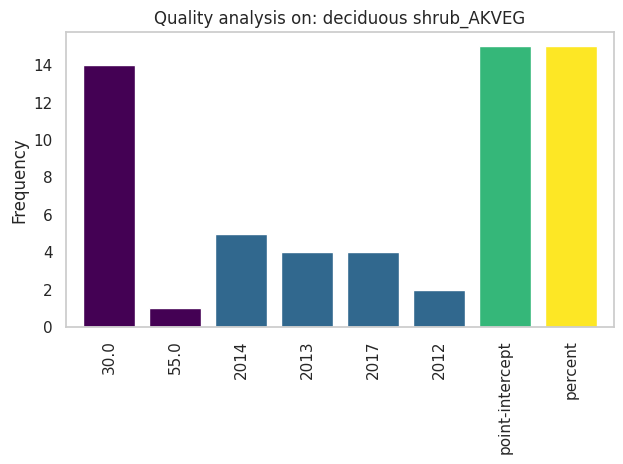

<Figure size 2500x2000 with 0 Axes>

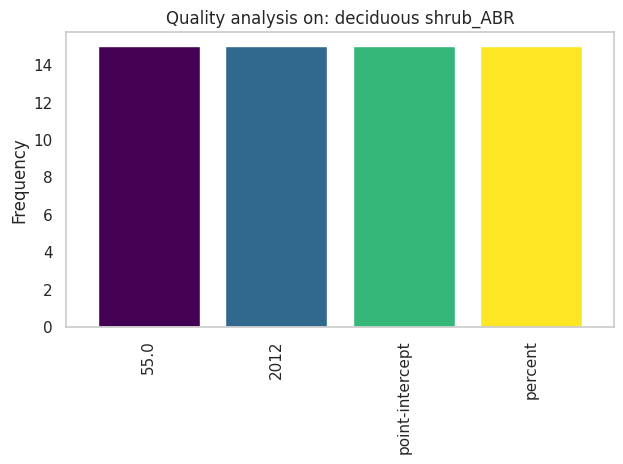

<Figure size 2500x2000 with 0 Axes>

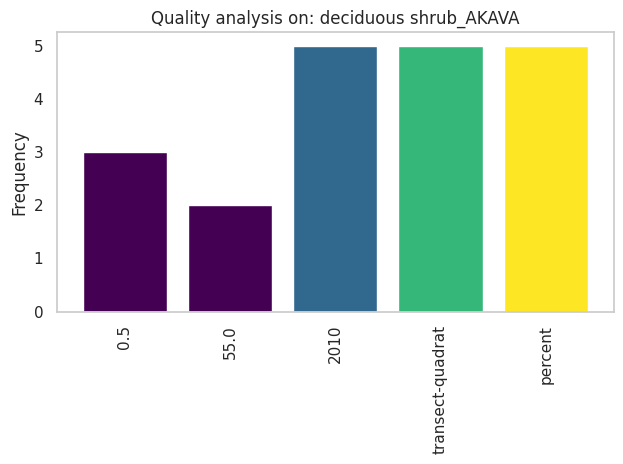

<Figure size 2500x2000 with 0 Axes>

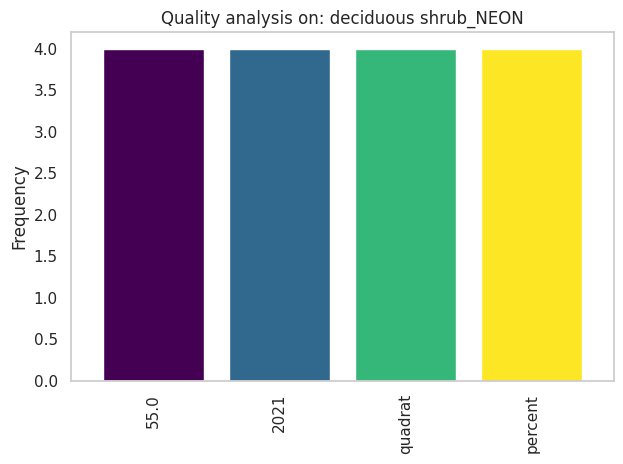

<Figure size 2500x2000 with 0 Axes>

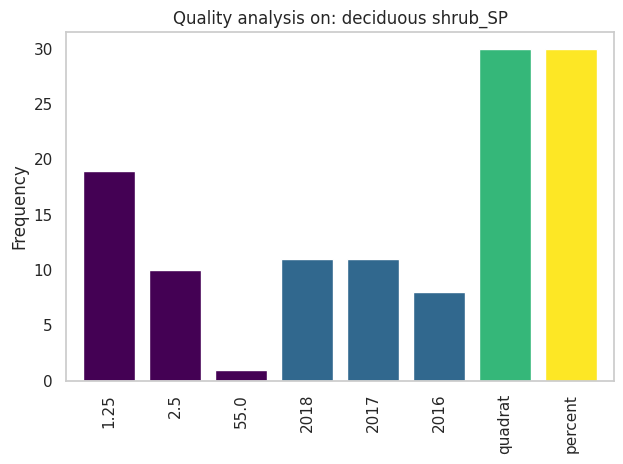

In [6]:
#### --- plot the dist of low-quality in terms of different aux info for each source ---

# Set the style of seaborn
sns.set(style="whitegrid")
data = source_bad.copy()

replacement_dict = {
    'source': {'AKVEG_AIM_NPRA': 'AKVEG', 'ABR_RS': 'ABR', 'NGEE_SP': 'SP'},
    'field sampling method': {'center-staked point-intercept transect': 'point-intercept'},
      # Add more columns and their replacement values as needed
}

data.replace(replacement_dict, inplace=True)

for src in data.source.unique():
    flag = data.source == src
    Data = data.copy().drop(columns = 'source')[flag]
    Data['year'] = Data['year'].astype(int).astype(str)
    
    # Create an empty DataFrame to store the frequencies
    stacked_data = pd.DataFrame()

    for col in Data.columns:
        counts = Data[col].value_counts()
        stacked_data = pd.concat([stacked_data, counts], axis=1)
    
    # Fill NaN values with 0
    stacked_data = stacked_data.fillna(0)
    
    # Create a stacked barplot
    plt.figure(figsize=(25, 20))
    ax = stacked_data.plot(kind='bar', stacked=True, colormap="viridis", width=0.8, legend=False)
    # ax.legend(labels=data.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set labels and title
    # plt.xlabel("Unique Values")
    plt.ylabel("Frequency")
    plt.title("Quality analysis on: " + PFT + '_' + src);
    ax.grid(False)
    plt.tight_layout()
    # Show the plot
    # plt.show()
    
    output_filename = os.path.join(result_path, 'QualityAnalysis_on_{}_{}.png'.format(PFT,src))
    plt.savefig(output_filename)

<Figure size 2500x2000 with 0 Axes>

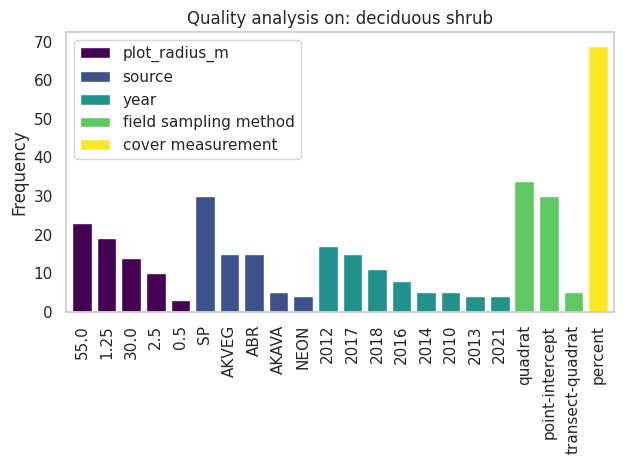

In [6]:
#### --- plot all low-quality samples, regardless of the source  ---
# Create an empty DataFrame to store the frequencies
stacked_data = pd.DataFrame()

# Loop through each column and store the frequencies
for col in data.columns:
    counts = data[col].value_counts()
    stacked_data = pd.concat([stacked_data, counts], axis=1)

# Fill NaN values with 0
stacked_data = stacked_data.fillna(0)

# Create a stacked barplot
plt.figure(figsize=(25, 20))
ax = stacked_data.plot(kind='bar', stacked=True, colormap="viridis", width=0.8)
# ax.legend(labels=data.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(labels=data.columns)

# Set labels and title
# plt.xlabel("Unique Values")
plt.ylabel("Frequency")
plt.title("Quality analysis on: " + PFT);
ax.grid(False)
plt.tight_layout()
# Show the plot
# plt.show()

output_filename = os.path.join(result_path, 'QualityAnalysis_on_{}.png'.format(PFT))
plt.savefig(output_filename)

### Fractional Cover Regression

In [5]:
### store auxiliary info for quality examination and plot selection
plot_aux = plot_fcover_cooks.copy()[['Site Code','plot_radius_m', 'source', 'year']]
plot_fea = plot_fea.drop(columns = ['Site Code', 'source'])

#extract all columns with specified PFT
target = plot_fcover_cooks.copy().filter(like=PFT)
# target.head()

## refined_id: < critical distance
cooks = target.filter(like='cooks')
thres = (np.quantile(cooks,0.75) - np.quantile(cooks,0.25))*2 + np.quantile(cooks,0.75)
target['ref_id'] = cooks < thres 
# target.head()

## divide the data into val and training part (orig)
flag_val = target['val_' + PFT]
y_orig, y_test, orig_aux, x_orig, x_test, ref_id = target[PFT][~flag_val], target[PFT][flag_val], plot_aux[~flag_val], plot_fea[~flag_val],plot_fea[flag_val], target['ref_id'][~flag_val]

## identified the refined samples
x_ref, y_ref, ref_aux = x_orig[ref_id], y_orig[ref_id],orig_aux[ref_id]
print(x_ref.columns)
# print(ref_aux.shape)

## the entire high-quality samples including the validation data
flag_highquality = target['ref_id']
x_train, y_train, highQuality_aux = plot_fea[flag_highquality], target[PFT][flag_highquality], plot_aux[flag_highquality]
print(x_train.shape)
print(y_train.shape)

Index(['blue', 'green', 'red', 'redEdge1', 'redEdge2', 'redEdge3', 'redEdge4',
       'nir', 'swir1', 'swir2', 'ndwi1', 'ndwi2', 'msavi', 'vari', 'rvi',
       'osavi', 'tgi', 'gli', 'ngrdi', 'ci_g', 'gNDVI', 'cvi', 'mtvi2',
       'brightness', 'greenness', 'wetness', 'tcari', 'tci', 'nari', 'VH',
       'VV', 'aspect', 'elevation', 'hillshade', 'slope'],
      dtype='object')
(445, 35)
(445,)


#### fit the initial played best base model and plot the feature importance

In [7]:
src = highQuality_aux.source.unique()
src[0:5]

array(['AKVEG_AIM_NPRA', 'ABR_RS', 'AKAVA', 'NEON', 'NGEE_SP'],
      dtype=object)

In [8]:
#--- random forest regression and plot the results ---
src = highQuality_aux.source.unique()
i = 5
flag_src = highQuality_aux['source'].isin(src[0:i])
X_train, y_train = x_train[flag_src],y_train[flag_src]

RF = RandomForestRegressor(n_estimators=100, max_depth=10, max_features = 10,random_state=42)
base_model = RF.fit(X_train, y_train)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#%% feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(RF, X_train, y_train, random_state=42,n_jobs=4)
varImportance = pd.DataFrame()
varImportance['Importance'] = list(result.importances_mean)
varImportance['std'] = list(result.importances_std)
varImportance['features'] = X_train.columns
varImportance = varImportance.set_index('features')
varImportance = varImportance.sort_values('Importance', ascending=True)

#%% plot the feature importance
plt.style.use('ggplot')
plt.rcParams.update({"lines.markeredgewidth" : 1,
                      "errorbar.capsize" : 2,
                      "font.family":"sans-serif"})
s = pd.Series(varImportance['Importance'].T)
err = list(varImportance['std'])
plt.figure(figsize = (3.5,5))
s.plot(kind='barh', xerr=err)
plt.ylabel('')
plt.legend(loc='lower right')
plt.axis('on')
# plt.xticks([0,0.1,0.2,0.3,0.4])
# plt.xlabel('Feature Importance')
plt.tight_layout()
# plt.show()
output_filename = os.path.join(result_path, 'FeatureImportance_{}.png'.format(PFT))
plt.savefig(output_filename)
plt.close()

#### model tuning with cross-validation

In [9]:
src = ref_aux.source.unique()
flag_src = ref_aux['source'].isin(src[0:i])
X_train, y_train = x_ref[flag_src],y_ref[flag_src]

nEstimators = [50, 100, 150, 200]
maxDepth = [50, 100, 150, 200]
maxFeatures = [5, 10, 15]
cv_results = np.zeros((len(nEstimators)*len(maxDepth)*len(maxFeatures), 6))

count = 0
for estimator in nEstimators:
    for depth in maxDepth:
        for features in maxFeatures:
            rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth, 
                                                 max_features = features,random_state=42)
            base_model = rf.fit(X_train, y_train)
            yhat_RF = base_model.predict(x_test)
            pred = yhat_RF.copy()  # change to another yhat
            test = y_test.copy()
            
            flag = np.logical_and(~np.isnan(pred) , ~np.isnan(test))
            pred = pred[flag]
            test = test[flag]
            res = stats.linregress(pred,test)
            r_squared = res.rvalue**2
            mse = mean_squared_error(pred,test)
            rmse = mse ** 0.5
            mae = mean_absolute_error(pred,test)
            cv_results[count, 0] = estimator
            cv_results[count, 1] = depth
            cv_results[count, 2] = features
            cv_results[count, 3] = r_squared
            cv_results[count, 4] = rmse
            cv_results[count, 5] = mae
            count += 1
            # print(estimator)

cv_results = pd.DataFrame(cv_results, columns=['n_estimator', 'max_depth', 'max_features','r_squared','rmse','mae'])
# Rank column 'A' and store the ranks in a new column 'A_rank'
cv_results['rank_r2'] = cv_results['r_squared'].rank(ascending=False, method='max')

# Sort the DataFrame based on the 'A_rank' column in descending order
cv_sorted = cv_results.sort_values(by='rank_r2')
cv_sorted.to_csv(os.path.join(result_path, 'ModelTuning_{}.csv'.format(PFT)))
display(cv_sorted.head(10)) 

,n_estimator,max_depth,max_features,r_squared,rmse,mae,rank_r2
0,50.0,50.0,5.0,0.936020,0.052226,0.036059,4.0
3,50.0,100.0,5.0,0.936020,0.052226,0.036059,4.0
9,50.0,200.0,5.0,0.936020,0.052226,0.036059,4.0
6,50.0,150.0,5.0,0.936020,0.052226,0.036059,4.0
21,100.0,200.0,5.0,0.935483,0.050276,0.034864,8.0
18,100.0,150.0,5.0,0.935483,0.050276,0.034864,8.0
12,100.0,50.0,5.0,0.935483,0.050276,0.034864,8.0
15,100.0,100.0,5.0,0.935483,0.050276,0.034864,8.0
30,150.0,150.0,5.0,0.933646,0.049932,0.035701,12.0
27,150.0,100.0,5.0,0.933646,0.049932,0.035701,12.0


#### --- plot the regression result using the best tuned model ----

In [10]:
# #%% ---- plot the regression result using the best tuned model ----
rf = RandomForestRegressor(n_estimators=50, max_depth=50, max_features = 5,random_state=42)
base_model = rf.fit(X_train, y_train)
yhat_RF = base_model.predict(x_test)
pred = yhat_RF.copy()  # change to another yhat
test = y_test.copy()

flag = np.logical_and(~np.isnan(pred) , ~np.isnan(test))
pred = pred[flag]
test = test[flag]
data = pd.DataFrame(data = {'predicted': pred, 'observed': test})
    
#create scatterplot with regression line
plt.figure(figsize=(4,3))
# plot 1:1 line
plt.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)

sns.regplot(data, x= 'predicted', y='observed',ci=95, marker="o",
            color="grey", 
            line_kws=dict(color="r",linewidth=1), 
            scatter_kws = dict(s=10))

# # Calculate R-squared value
res = stats.linregress(pred,test)
r_squared = res.rvalue**2
mse = mean_squared_error(pred,test)
rmse = mse ** 0.5
mae = mean_absolute_error(pred,test)

# text = f'$R^2={r_squared:.2f}$'
plt.text(0.05, 0.88, f'$R^2={r_squared:.2f}$', fontsize=8.5, color = 'blue')
plt.text(0.05, 0.8, f'$MAE: {mae:.2f}$', fontsize=8.5, color = 'blue')
plt.text(0.05, 0.72, f'$RMSE: {rmse:.2f}$', fontsize=8.5, color = 'blue')

count = y_train.shape[0]
plt.text(0.6, 0.1, f'$Count: {count:.0f}$', fontsize=8.5, color = 'black')

# ax.set_title('+'.join(src[0:i+1]))
plt.title('source' + str(i))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.yticks([0,0.2,0.4,0.6,0.8,1])
    
plt.xlabel("predicted", fontsize = 11)
plt.ylabel("observed", fontsize = 11)
plt.tight_layout()
    
output_filename = os.path.join(result_path, 'scatterplot_bestModel_{}.png'.format(PFT))
plt.savefig(output_filename)
plt.close()

#### regression using all refined samples with the best parameter settings

In [11]:
## the entire high-quality samples including the validation data
flag_highquality = target['ref_id']
x_train, y_train, highQuality_aux = plot_fea[flag_highquality], target[PFT][flag_highquality], plot_aux[flag_highquality]
print(x_train.shape)
print(y_train.shape)

all_model = rf.fit(x_train, y_train)

(445, 35)
(445,)


#### Pickle the trained model to a file

In [12]:
import pickle

model_file_path = os.path.join(result_path, 'tunedModel_{}.pkl'.format(PFT))
with open(model_file_path, 'wb') as model_file:
    pickle.dump(all_model, model_file)

# # Load the pickled model from the file
# with open(model_file_path, 'rb') as model_file:
#     loaded_model = pickle.load(model_file)